In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%load_ext autoreload
%autoreload 2

In [12]:
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v1.h5")
at.set_included_mice([409828])

In [3]:
client = OPhysClient("/Users/chase/Desktop/test_v1dd_data/")

In [4]:
session_id = "M409828_13"
session = client.load_ophys_session(session_id)

In [29]:
for session_group, _ in iter_plane_groups(filter=dict(session_id=session_id), return_session_group=True):
    dups = [eval(x.decode()) for x in session_group["duplicate_rois"]["all_duplicates"][()]]
    break

In [31]:
roi_plane = {} # (plane, roi): plane

for dup_set in dups:
    actual_plane, actual_roi = dup_set[0]
    other_rois = dup_set[1:]

    for r in other_rois:
        roi_plane[r] = actual_plane

len(roi_plane)

807

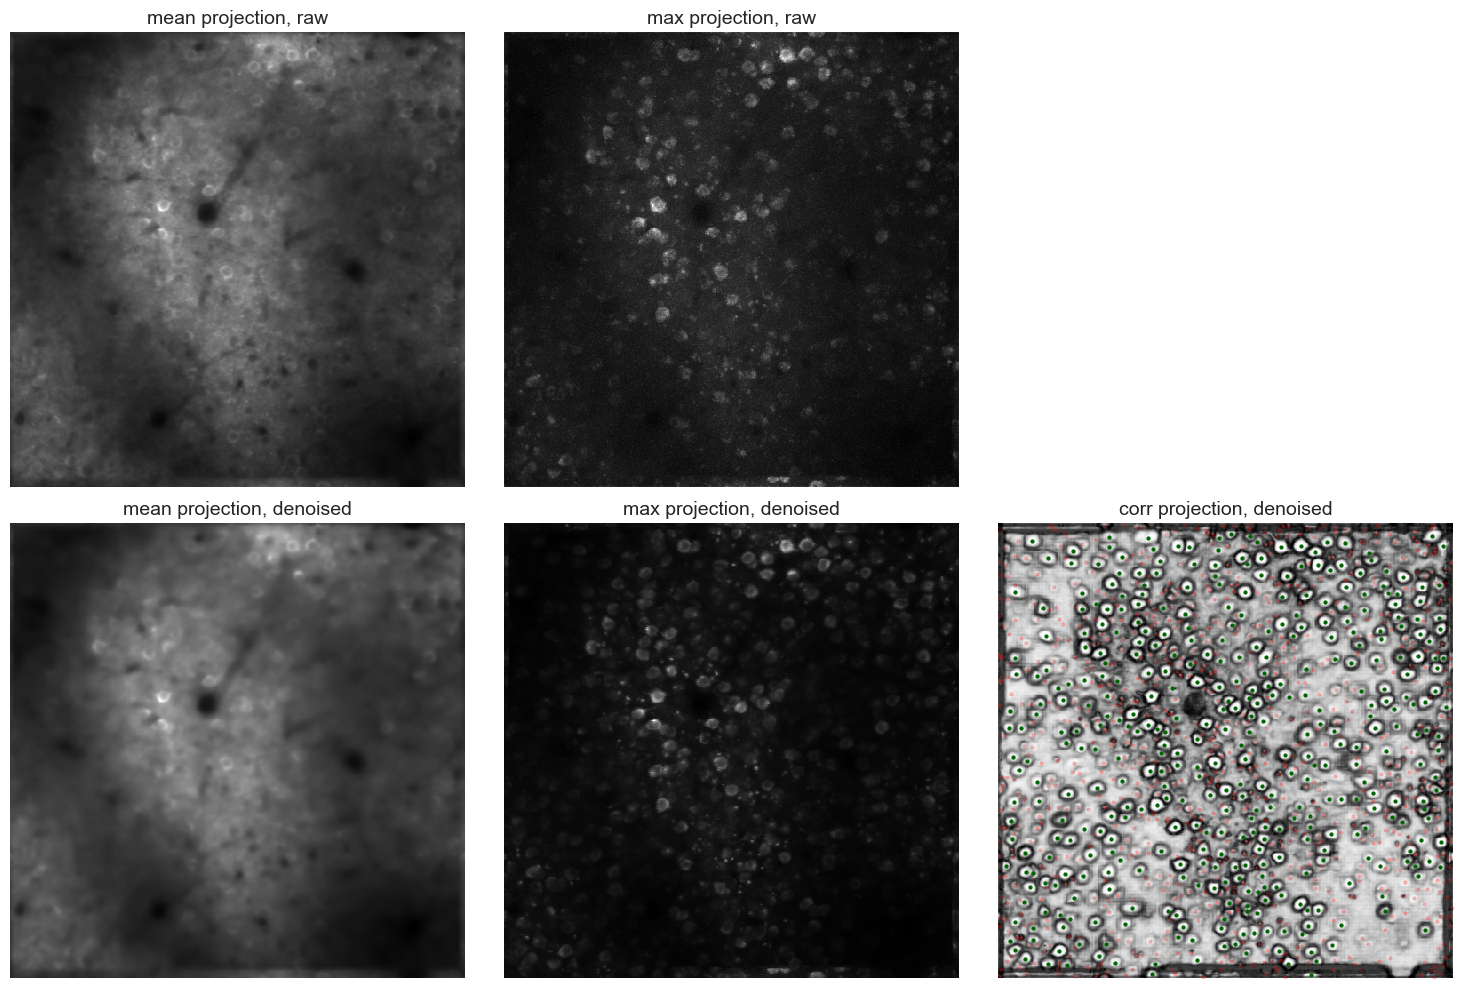

In [42]:
sess, plane = session, session.get_planes()[0]
proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(plane)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axs[0, 0].imshow(proj_raw_mean, cmap='gray', interpolation='nearest')
axs[0, 0].set_title('mean projection, raw')
axs[0, 1].imshow(proj_raw_max, cmap='gray', interpolation='nearest')
axs[0, 1].set_title('max projection, raw')
axs[1, 0].imshow(proj_de_mean, cmap='gray', interpolation='nearest')
axs[1, 0].set_title('mean projection, denoised')
axs[1, 1].imshow(proj_de_max, cmap='gray', interpolation='nearest')
axs[1, 1].set_title('max projection, denoised')
axs[1, 2].imshow(proj_de_corr, cmap='gray', interpolation='nearest')
axs[1, 2].set_title('corr projection, denoised')

for roi in sess.get_rois(plane):
    valid = sess.is_roi_valid(plane, roi)
    # if not valid:
    mask = sess.get_roi_image_mask(plane, roi)
    centroid_y, centroid_x = np.mean(np.where(mask), axis=1)
    axs[1, 2].scatter(centroid_x, centroid_y, color=("darkgreen" if valid else "red"), s=5, alpha=(1 if valid else 0.2))


for ax in axs.flat:
    ax.set_axis_off()

fig.tight_layout()

In [53]:
for plane in tqdm(session.get_planes()):
    proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = session.get_plane_projection_images(plane)
    fig, ax = plt.subplots(figsize=(12, 12))
    
    ax.imshow(proj_raw_max, cmap="gray", interpolation="nearest")
    ax.set_title(f"{session_id}, Plane {plane}")

    for roi in np.where(session.is_roi_valid(plane))[0]:
        mask = session.get_roi_image_mask(plane, roi)
        centroid_y, centroid_x = np.mean(np.where(mask), axis=1)
        actual_plane = roi_plane.get((plane, roi), plane)
        color = "green" if actual_plane == plane else "red"
        # ax.text(x=centroid_x, y=centroid_y, s=f"{roi}", fontsize=10, color=color, ha="center", va="center")
        ax.scatter(x=centroid_x, y=centroid_y, s=4, color=color)
    
    fig.savefig(f"/Users/chase/Desktop/dup_test/max_proj_raw_{plane}.png", bbox_inches="tight")
    plt.close(fig)

  0%|          | 0/6 [00:00<?, ?it/s]